In [1]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString,Point, Polygon, shape
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
import io
from PIL import Image
import requests
from io import BytesIO
import os
import pickle
from tqdm import tqdm
import dpkt
# from Utils import get_foreground_point_cloud
from LiDARBase import parse_one_packet,calc_precise_azimuth,laser_id,Data_order,arg_omega,calc_timing_offsets,get_foreground_point_cloud
from Utils import *
from GenBckFile import *
# use sobel filter to get horizontal gradient
from scipy import ndimage
from scipy.signal import convolve2d
from DDBSCAN import *
import statistics


pygame 2.5.2 (SDL 2.28.3, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# unix time to utc time to pacific time
def unix2utc(unix_time):
    return pd.to_datetime(unix_time,unit='s').tz_localize('UTC').tz_convert('US/Pacific')
def load_pcap(file_path):
    try:
        fpcap = open(file_path, 'rb')
        eth_reader = dpkt.pcap.Reader(fpcap)
    except Exception as ex:
        print(str(ex))
        return None
    return eth_reader
    
def read_packets_offline(pcap_file_path):
    eth_reader = load_pcap(pcap_file_path)
    while True:
        # Simulate reading a packet from the Ethernet
        try:
            ts,buf = next(eth_reader)
        except StopIteration:
            return None
        eth = dpkt.ethernet.Ethernet(buf)
        if eth.type == 2048: # for ipv4
            if (type(eth.data.data) == dpkt.udp.UDP):# for ipv4
                data = eth.data.data.data
                packet_status = eth.data.data.sport
                if packet_status == 2368:
                    if len(data) != 1206:
                        continue
            # raw_packet = np.random.rand(20000,2) * 600  # Placeholder for actual packet data
                    yield (ts,data)
                    
def parse_packets(packet_gen):
    
    culmulative_azimuth_values = []
    culmulative_laser_ids = []
    culmulative_distances = []
    # culmulative_intensities = []
    Td_map = np.zeros((32,1800))
    # Intens_map = np.zeros((32,1800))
    next_ts = 0
    packet = next(packet_gen)
    if packet is None:
        return None
    ts,raw_packet = packet
    distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(raw_packet)
    next_ts = ts + 0.1 # 0.1sec
    azimuth = calc_precise_azimuth(azimuth_per_block) # 32 x 12
    culmulative_azimuth_values.append(azimuth)
    culmulative_laser_ids.append(laser_id)
    culmulative_distances.append(distances)
            
    break_flag = False
    while True:
        if break_flag:
            break  
        while True:
            try:
                packet = next(packet_gen)
            except StopIteration:
                break_flag = True
                break
            ts,raw_packet = packet
            # Placeholder for parsing logic; here we just pass the data through
            distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(raw_packet)
            # flag = self.if_rollover(azimuth_per_block,Initial_azimuth)
            azimuth = calc_precise_azimuth(azimuth_per_block) # 32 x 12
            
            if ts > next_ts:
                
                if len(culmulative_azimuth_values) > 0:
                    
                    culmulative_azimuth_values = np.concatenate(culmulative_azimuth_values,axis = 1)
                    culmulative_azimuth_values += Data_order[:,1].reshape(-1,1)
                    culmulative_laser_ids = np.concatenate(culmulative_laser_ids,axis = 1).flatten()
                    culmulative_distances = np.concatenate(culmulative_distances,axis = 1).flatten()
                    # culmulative_intensities = np.concatenate(culmulative_intensities,axis = 1).flatten()
                    culmulative_azimuth_inds = np.around(culmulative_azimuth_values/0.2).astype('int').flatten()
                    culmulative_azimuth_inds[(culmulative_azimuth_inds<0)|(culmulative_azimuth_inds>1799)] = culmulative_azimuth_inds[(culmulative_azimuth_inds<0)|(culmulative_azimuth_inds>1799)]%1799

                    Td_map[culmulative_laser_ids,culmulative_azimuth_inds] = culmulative_distances
                    # Intens_map[culmulative_laser_ids,culmulative_azimuth_inds] = culmulative_intensities
                    
                    yield Td_map[arg_omega,:] #32*1800
                else:
                    yield Td_map,ts #32*1800

                culmulative_azimuth_values = []
                culmulative_laser_ids = []
                culmulative_distances = []
                # culmulative_intensities = []

                Td_map = np.zeros((32,1800))
                # Intens_map = np.zeros((32,1800))
                next_ts += 0.1
                break
            else:
                culmulative_azimuth_values.append(azimuth)
                culmulative_laser_ids.append(laser_id)
                culmulative_distances.append(distances)
                # culmulative_intensities.append(intensities)
    return None

In [3]:
Td_maps = []
pcap_file_path = r'D:\LiDAR_Data\9thVir\2024-03-14-23-30-00.pcap'
packets_gen = read_packets_offline(pcap_file_path)
packet = next(packets_gen)
Initial_ts,raw_packet = packet

packets_gen = read_packets_offline(pcap_file_path)
td_gen = parse_packets(packets_gen)
for Td_map in tqdm(td_gen):
    Td_maps.append(Td_map)

17989it [08:07, 36.91it/s]


In [99]:
# unix time to utc time to pacific time
Initial_ts = unix2utc(Initial_ts)

In [280]:

background_data = np.array(Td_maps)
thred_map = gen_bckmap(np.array(background_data), N = 10,d_thred = 0.1,bck_n = 3)         

100%|██████████| 32/32 [01:15<00:00,  2.37s/it]


In [ ]:
np.save('./thred_map.npy',thred_map)
thred_map = np.load('./thred_map.npy')

In [354]:
bck_radius = 0.3
vertical_limits = [0,31]
lane_drawer = LaneDrawer() # lane drawer for queue detection
lane_drawer.update_lane_gdf()

Lane zone updated


In [401]:
count_thred = 3
time_space_series = [] # t x laen# x lane_section#
for Td_map in tqdm(Td_maps):
    
    data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
                                                                            Td_map,vertical_limits)
    if len(data_raw) == 0:
        time_space_series.append(None)
        continue
    lane_section_foreground_point_counts = get_lane_section_foreground_point_counts(lane_drawer.lane_subsections_poly,
                                                                                lane_drawer.lane_gdf,
                                                                                data_raw,point_labels)
    activation_profile = []
    for lane_counts in lane_section_foreground_point_counts:
        occupation = np.array(lane_counts) > count_thred
        activation_profile.append(occupation)
    time_space_series.append(activation_profile)
# test_time_space_series = np.array(test_time_space_series)

100%|██████████| 17989/17989 [26:43<00:00, 11.22it/s]


In [453]:
lane_ind = 0
lane_activation_profile = []
for t in range(len(time_space_series)):
    lane_activation_cur = time_space_series[t][lane_ind]
    lane_activation_profile.append(lane_activation_cur)
lane_activation_profile = np.array(lane_activation_profile,dtype=int)
lane_activation_profile_T = lane_activation_profile.T

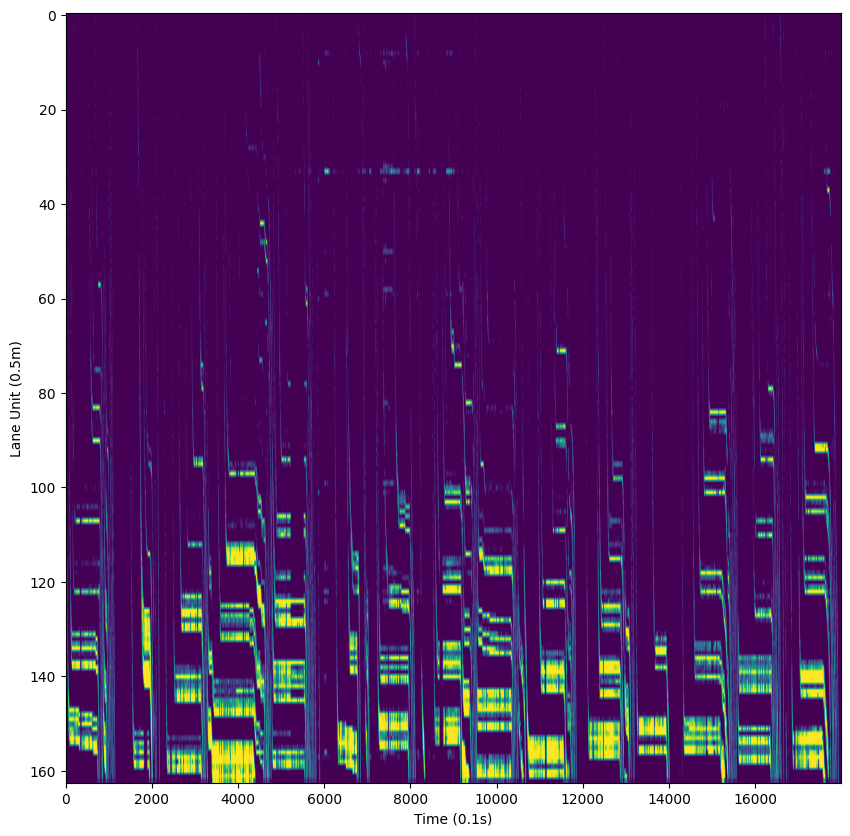

In [454]:
plt.figure(figsize = (10,10))
plt.imshow(lane_activation_profile_T,aspect = 'auto',interpolation = None)
plt.xlabel('Time (0.1s)')
plt.ylabel('Lane Unit (0.5m)')
# plt.xlim(12000,15500)
plt.show()

In [455]:
lane_activation_profile_T = lane_activation_profile.T
stop_specturm = ndimage.sobel(lane_activation_profile_T, 0)  # horizontal gradient
# travel_specturm = ndimage.sobel(lane_activation_profile_T, 1)  # horizontal gradient
empty_specturm = np.zeros(lane_activation_profile_T.shape,dtype=np.uint8)
lines = cv2.HoughLinesP(image= (stop_specturm > 0).astype(np.uint8),rho=1,theta=np.pi/2,threshold=50,minLineLength=50,maxLineGap=5)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(empty_specturm,(x1,y1),(x2,y2),(1,0,0),2)

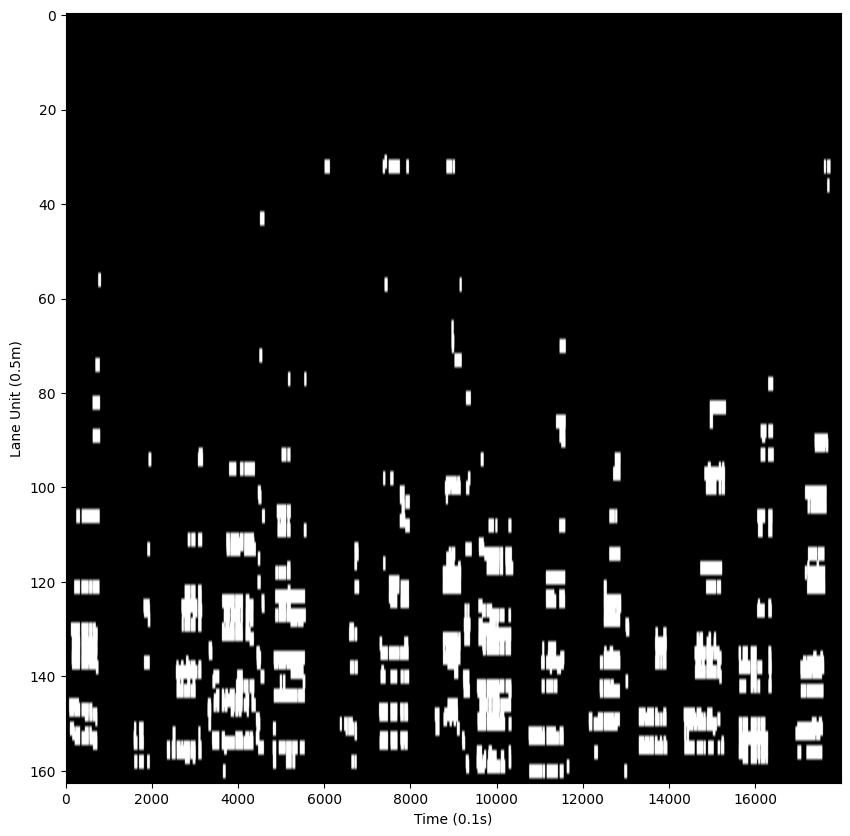

In [456]:
plt.figure(figsize = (10,10))
# increase distincness of the image
plt.imshow(empty_specturm,aspect = 'auto',cmap='gray',interpolation = None)
# plt.imshow(sobel_v,aspect = 'auto',cmap='gray',interpolation = None)
plt.xlabel('Time (0.1s)')
plt.ylabel('Lane Unit (0.5m)')
# plt.xlim(14000,15500)# plt.ylim(0,32)
plt.show()

In [489]:
queue_length_indicator = empty_specturm != 0

total_queue_length_curve = []
for i in range(0,queue_length_indicator.shape[1],1):
    stops = np.where(queue_length_indicator[:,i])[0]
    if len(stops) == 0:
        total_queue_length_curve.append(0)
        continue
    queue_length_t = (queue_length_indicator.shape[0] - stops.min()) * 0.5
    total_queue_length_curve.append(queue_length_t)
total_queue_length_curve = np.array(total_queue_length_curve)
# sample at 10 frames
total_queue_length_curve = total_queue_length_curve[::10]

In [496]:
total_queue_length_curve.shape

(1799,)

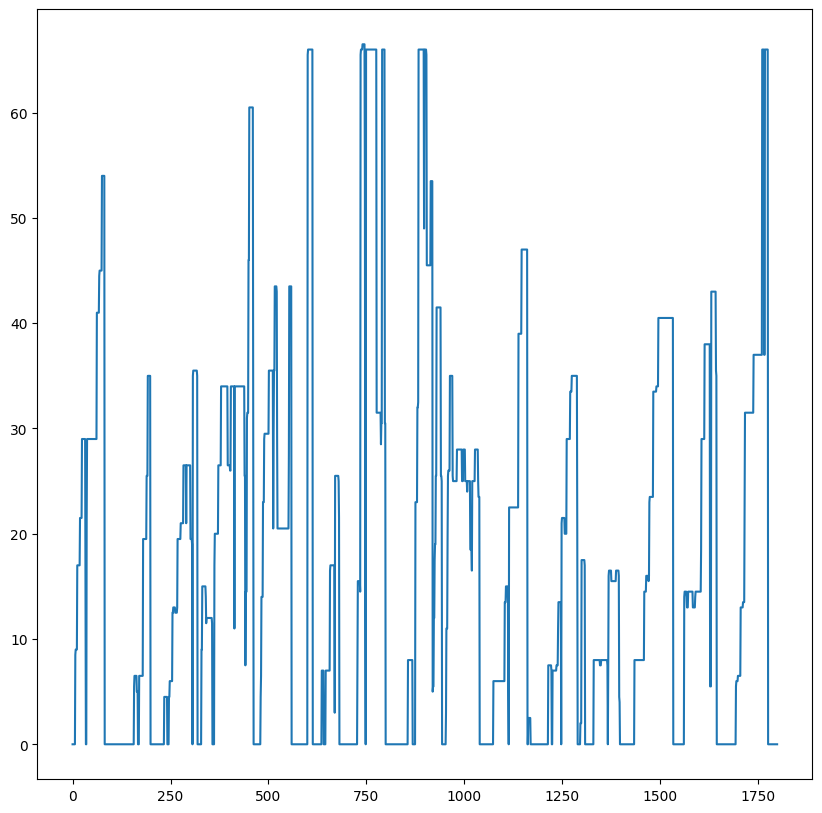

In [497]:
plt.figure(figsize = (10,10))

plt.plot(total_queue_length_curve)
# plt.xlim(14000,18000)

plt.show()

In [494]:
# define a kernal to identify a sudden change toward upper direction
kernal = np.array([0] * 10 + [1] * 5)
volumes = []
for i in range(1,10):
    activation = lane_activation_profile_T[-i,:]
    # convolve the kernal with the lane_activation_profile_T
    convolution = np.convolve(activation,kernal,mode='same')
    passing_incator = convolution > 0
    activation_start,activation_end = find_concecutive_activation(passing_incator)
    # activation_end = np.array(activation_end)
    activation_start = np.array(activation_start)
    volume_section = []
    for ts in range(10,lane_activation_profile_T.shape[1] + 10,10):
        volume_section.append(((activation_start < ts)&(activation_start > ts - 10)).sum())
    volumes.append(volume_section)
volumes = np.array(volumes)
volumes_sec = []
for i in range(volumes.shape[1]):
    volumes_sec.append(statistics.mode(volumes[:,i]))
volumes_sec = np.array(volumes_sec)
    

## Summary 

In [ ]:
count_thred = 3 # activation point cloud # threshold
bck_radius = 0.2
vertical_limits = [0,31]
lane_drawer = LaneDrawer() # lane drawer for queue detection
lane_drawer.update_lane_gdf()


def main(pcap_file_path,lane_drawer,out_path):
    
    # extract the pcap_file name of the pcap_file_path and exclude the .pcap extension
    pcap_file_name = os.path.basename(pcap_file_path).split('.')[0]
    # create a folder to store the output by the pcap_file name and out_path
    out_folder = os.path.join(out_path,pcap_file_name)
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
     
    Td_maps = []
    packets_gen = read_packets_offline(pcap_file_path)
    packet = next(packets_gen)
    Initial_ts,raw_packet = packet
    # unix time to utc time to pacific time
    Initial_date = unix2utc(Initial_ts)
    packets_gen = read_packets_offline(pcap_file_path)
    td_gen = parse_packets(packets_gen)
    for Td_map in tqdm(td_gen):
        Td_maps.append(Td_map)
    
    background_data = np.array(Td_maps)
    thred_map = gen_bckmap(np.array(background_data), N = 10,d_thred = 0.1,bck_n = 3)
    # save thred_map as .npy file in out_folder
    np.save(os.path.join(out_folder,'thred_map.npy'),thred_map)
    
    time_space_series = [] # t x laen# x lane_section#
    for Td_map in tqdm(Td_maps):
        data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
                                                                                Td_map,vertical_limits)
        if len(data_raw) == 0:
            time_space_series.append(None)
            continue
        lane_section_foreground_point_counts = get_lane_section_foreground_point_counts(lane_drawer.lane_subsections_poly,
                                                                                    lane_drawer.lane_gdf,
                                                                                    data_raw,point_labels)
        activation_profile = []
        for lane_counts in lane_section_foreground_point_counts:
            occupation = np.array(lane_counts) > count_thred
            activation_profile.append(occupation)
        time_space_series.append(activation_profile)
    time_space_series = np.array(time_space_series)


    for lane_ind in range(len(lane_drawer.lane_subsections_poly)):
        lane_activation_profile = []
        for t in range(len(time_space_series)):
            lane_activation_cur = time_space_series[t][lane_ind]
            lane_activation_profile.append(lane_activation_cur)
        lane_activation_profile = np.array(lane_activation_profile,dtype=int)
        lane_activation_profile_T = lane_activation_profile.T
        stop_specturm = ndimage.sobel(lane_activation_profile_T, 0)  # horizontal gradient
        empty_specturm = np.zeros(lane_activation_profile_T.shape,dtype=np.uint8)
        lines = cv2.HoughLinesP(image= (stop_specturm > 0).astype(np.uint8),rho=1,theta=np.pi/2,threshold=100,minLineLength=50,maxLineGap=5)
        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(empty_specturm,(x1,y1),(x2,y2),(1,0,0),2)
                     
    queue_length_indicator = empty_specturm != 0
    total_queue_length_curve = []
    for i in range(0,queue_length_indicator.shape[1],1):
        stops = np.where(queue_length_indicator[:,i])[0]
        if len(stops) == 0:
            total_queue_length_curve.append(0)
            continue
        queue_length_t = (queue_length_indicator.shape[0] - stops.min()) * 0.5
        total_queue_length_curve.append(queue_length_t)
    total_queue_length_curve = np.array(total_queue_length_curve)
    # sample at 10 frames
    total_queue_length_curve = total_queue_length_curve[::10]

    # define a kernal to identify a sudden change toward upper direction
    kernel = np.array([0] * 10 + [1] * 5)
    volumes = []
    for i in range(1,10):
        activation = lane_activation_profile_T[-i,:]
        # convolve the kernal with the lane_activation_profile_T
        convolution = np.convolve(activation,kernel,mode='same')
        passing_incator = convolution > 0
        activation_start,activation_end = find_concecutive_activation(passing_incator)
        # activation_end = np.array(activation_end)
        activation_start = np.array(activation_start)
        volume_section = []
        for ts in range(10,lane_activation_profile_T.shape[1],10):
            volume_section.append(((activation_start < ts)&(activation_start > ts - 10)).sum())
        volumes.append(volume_section)
    volumes = np.array(volumes)
    volumes_sec = []
    for i in range(volumes.shape[1]):
        volumes_sec.append(statistics.mode(volumes[:,i]))
    volumes_sec = np.array(volumes_sec)






In [ ]:
total_queue_length_curve_resampled = [] 
time_stamps = []
for i in range(0,len(total_queue_length_curve),10):
    total_queue_length_curve_resampled.append(total_queue_length_curve[i])
    time_stamps.append(Initial_date + pd.Timedelta(seconds = i * 0.1))
# save to csv file
df = pd.DataFrame({'Time':time_stamps,'Queue_Length':total_queue_length_curve_resampled})

In [199]:
half_hour_delay = ((total_queue_length_curve/8.5) * 0.1).sum()/volume


In [197]:
test_cum = []
for i in range(1,int(lane_activation_profile_T.shape[0] * 0.3)):
    activation = lane_activation_profile_T[-i,:]
    # convolve the kernal with the lane_activation_profile_T
    convolution = np.convolve(activation,kernal,mode='same')
    passing_incator = convolution > 0
    activation_start,activation_end = find_concecutive_activation(passing_incator)
    activation_start = np.array(activation_start)
    test_cum.append(len(activation_start))
    
volume = statistics.mode(test_cum)

In [196]:
int(lane_activation_profile_T.shape[0] * 0.3)

47

In [194]:
test_cum[-10:]

[13, 45, 46, 53, 62, 62, 72, 64, 68, 60]

In [191]:
volume

60

In [182]:
activation_starts = []
for i in range(1,10):
    activation = lane_activation_profile_T[-i,:]
    # convolve the kernal with the lane_activation_profile_T
    convolution = np.convolve(activation,kernal,mode='same')
    passing_incator = convolution > 0
    activation_start,activation_end = find_concecutive_activation(passing_incator)
    activation_start = np.array(activation_start)
    activation_starts.append(activation_start)

In [180]:
len(lane_drawer.lane_subsections_poly)

11